In [127]:
import os
from cadtoolkit.pc2g import CoronaryGraph, _read_centerlines_txt


In [222]:
path = "../cartesian_data" # change this path

files = os.listdir(path)
if not os.path.exists('cartesian_graphs'):
    os.makedirs('cartesian_graphs')

In [224]:
print(files[2])
f= files[2]

AHG0133.txt


In [130]:
# this section is just a simplified version of text2graph.py
# for f in files: # uncomment this when sure its working...

g = CoronaryGraph() # creates empty graph 'g'
updated_g = g.from_txt(os.path.join(path, f))

# Save the CoronaryGraph() object
f_without_ext = os.path.splitext(f)[0] # remove .txt extension
updated_g.sg=None
updated_g.save(f"cartesian_graphs/{f_without_ext}")

converting points
converting point data
converting cell data
Writing VTK XML surface file.


/home/561/qp2123/miniconda3/envs/treelstm/lib/python3.7/site-packages/vmtk/vmtknumpytocenterlines.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(self.ArrayDict['PointData'][pointKey].dtype, float):
/home/561/qp2123/miniconda3/envs/treelstm/lib/python3.7/site-packages/vmtk/vmtknumpytocenterlines.py:65: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.ArrayDict['PointData'][pointKey].dtype, checkDt):


In [131]:
print(f"Start: {updated_g.startpts()}")
print(f"Bifs: {updated_g.bifurcations()}")
# print(f"Inner: {points.inner_points()}")
print(f"End: {updated_g.endpoints()}")


Start: {0, 4557}
Bifs: {13718, 13719, 13720, 13721, 13722}
End: {9448, 7465, 12648, 4556, 13263, 13717, 11806}


In [132]:
# for idx, val in updated_g.nodes.items():
#     print(idx, val)

In [133]:
# Showing info for random points
print(updated_g.nodes[0])
print(updated_g.nodes[10])

{'ids': 0, 'y_real': 8, 'R': 4.9172, 'Radius': 1.5, 'TCoords': array([0., 0.], dtype=float32), 'CenterlineIds': 0, 'TractIds': 0, 'Blanking': 0, 'GroupIds': 0, 'loc': array([   1.9243667,  -12.503833 , -111.58466  ], dtype=float32)}
{'ids': 0, 'y_real': 8, 'R': 4.9133043, 'Radius': 1.5, 'TCoords': array([0.01187648, 0.        ], dtype=float32), 'CenterlineIds': 0, 'TractIds': 0, 'Blanking': 0, 'GroupIds': 0, 'loc': array([   1.6299846,  -12.882071 , -111.57544  ], dtype=float32)}


In [134]:
# Plot graph 

# import networkx as nx
# from networkx.drawing.nx_agraph import graphviz_layout
# import matplotlib.pyplot as plt

# skeleton_graph = updated_g.collapse_intermediates()
# plt.title('Coronary Map')
# pos=graphviz_layout(skeleton_graph, prog='dot')
# nx.draw(skeleton_graph, pos, with_labels=True, arrows=True) # good
# plt.savefig('nx_test.png')

In [138]:
# Attempt to create Graph dataset
import torch
from torch_geometric.data import Data, DataLoader

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.6.0
10.2
True


In [139]:
from torch_geometric.utils import from_networkx
from torch_geometric.data import InMemoryDataset # base class

class GraphDataset(InMemoryDataset): # subclass from base class
    
    num_classes = 10
    num_node_features = 3
    
    def __init__(self, root, transform=None, pre_transform=None):
        # calling super class
        super(GraphDataset,self).__init__(root, transform, pre_transform) 
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [f"{self.root}"] # like calling super variables in Java

    @property
    def processed_file_names(self):
        return ['processed']

    def download(self):
        # Download to `self.raw_dir`.
        pass
    
    def process(self):
        # Read data into huge `Data` list.

        data_list = []

        files = os.listdir("graphs")
        for f in files:

            if f == ".ipynb_checkpoints": continue

            a = CoronaryGraph() # another empty graph
            loadedGraph = a.load(f"cartesian_graphs/{f}")
            skeleton_graph = loadedGraph.collapse_intermediates()
            data = from_networkx(skeleton_graph)
#             data.y = data.ids
            data.name = f
            data_list.append(data)
#             print(f"{f} \n {data}")

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

all_data = GraphDataset(root="cartesian")


In [140]:
# Split train and test data
import numpy as np

all_data = all_data.shuffle()

train_ratio = 0.8
threshold = int(train_ratio*len(all_data))

train_data, val_data = all_data[:threshold], all_data[threshold:]

print(len(train_data), len(val_data))

253 64


In [141]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [208]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GraphCNN(nn.Module):
    def __init__(self):
        super(GraphCNN, self).__init__()
        self.conv1 = GCNConv(train_data.num_node_features, 32)
        self.conv2 = GCNConv(32, 16)

    def forward(self, data):
        x, edge_index = data.loc, data.edge_index
        
        # 1st layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,p=0.1, training=self.training)
        
        x = self.conv2(x, edge_index)
        return x

class GraphCNN_Deep(nn.Module): # less accurate
    def __init__(self):
        super(GraphCNN_Deep, self).__init__()

        self.conv1 = GCNConv(train_data.num_node_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 32)
        self.conv4 = GCNConv(32, 16)

    def forward(self, data):
        x, edge_index = data.loc, data.edge_index
        
        # 1st layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,p=0.1, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,p=0.1, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x,p=0.1, training=self.training)

        x = self.conv4(x, edge_index)
        return x
    
class TreeLabNet(torch.nn.Module):
    def __init__(self, hidden_dim, emb_dim, num_linear=1):
        super().__init__()
        
        self.cnn=GraphCNN()
        
        self.lstm=nn.LSTM(
            input_size=emb_dim, 
            hidden_size=hidden_dim, 
            num_layers=1,
            bidirectional=True,
            dropout=0.2
        )    
        
        # fc layers
        self.fc1 = nn.Linear(hidden_dim*2, 64) #flattening. x2 because lstm is bidirectional
        self.fc2 = nn.Linear(64, train_data.num_classes) # 64 in, 9 out bc we're doing 9 classes 

    def forward(self, x): # used to be data
        
        x = self.cnn(x)
        
        x = x.view(-1, 1, x.shape[1])
#         print(x.shape)
        lstm_out, (h,c) = self.lstm(x)

#         lstm_out = lstm_out.view(-1, dim) 
        lstm_out = self.fc1(lstm_out)
        lstm_out = F.relu(lstm_out)
        
        lstm_out = self.fc2(lstm_out)
        
        dim = lstm_out.shape[1]*lstm_out.shape[2]
        lstm_out = lstm_out.view(-1, dim) 

        return F.log_softmax(lstm_out, dim=1)

In [209]:
torch.autograd.set_detect_anomaly(True) # checks code location that breaks 
BATCH_SIZE = 64

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE) # adjust batch size
valloader = DataLoader(val_data, batch_size=BATCH_SIZE) # adjust batch size

print(train_data[0])

Data(Blanking=[14], CenterlineIds=[14], GroupIds=[14], Radius=[14], TCoords=[14, 2], TractIds=[14], edge_index=[2, 12], ids=[14], loc=[14, 3], name="AP1224", y_real=[14])


In [210]:
def train():
    model.train()
    
    sumCorrect = 0
    sumTotal = 0 
    running_loss = 0
    for data in trainloader:

        optimizer.zero_grad()

        data = data.to(device)
        out = model(data)

        _, predicted = torch.max(out.data, 1)

        # Loss
        loss = F.nll_loss(out, data.y_real.long())
        running_loss += loss.item()

        # Accuracy
        sumCorrect += (predicted == data.y_real).sum().item()
        sumTotal += data.y_real.size(0)

        # retain_graph=False in this case 
        # https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method
        loss.backward() 
        optimizer.step()

    total_loss_per_epoch = round(running_loss/len(trainloader), 3)
    acc = round(sumCorrect/sumTotal, 3)

    return acc, total_loss_per_epoch
#         print(f"Epoch {epoch+1} ----- Accuracy: {acc} Loss: {total_loss_per_epoch}")

In [211]:
def evaluate():
    model.eval()
    
    predicted_class_array, true_class_array = [], []
    sumCorrect = 0
    sumTotal = 0 
    running_loss = 0
    
    with torch.no_grad():
        for data in valloader:
            data = data.to(device)
            out = model(data)
    #         print(out.data.shape)
            _, predicted = torch.max(out.data, 1)
            
            # Loss
            loss = F.nll_loss(out, data.y_real.long())
            running_loss += loss.item()

            # Accuracy
            sumCorrect += (predicted == data.y_real).sum().item()
            sumTotal += data.y_real.size(0)
            
            # adding predicted and true labels
            pred = predicted.cpu().data.numpy()
            predicted_class_array.extend(pred)
            true_class_array.extend(data.y_real.tolist())

#             loss.backward(retain_graph=True)
    total_loss_per_epoch = round(running_loss/len(valloader), 3)
    acc = round(sumCorrect/sumTotal, 3)
    return acc, total_loss_per_epoch, predicted_class_array, true_class_array
    

In [212]:
'''
For LSTM
https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#torch.nn.LSTM 
'''
num_expected_features = 16
nh = 30 # no of hidden units for lstm
nl = 1 # no of recurrent layers

alpha = 0.001

criterion = nn.NLLLoss()
model = TreeLabNet(hidden_dim=nh, emb_dim=num_expected_features, num_linear=nl).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=alpha, weight_decay=1e-5) 

In [219]:
EPOCHS = 50
train_acc_list, train_loss_list, val_acc_list, val_loss_list = [],[],[],[]
for epoch in range(EPOCHS):

    sumCorrect = 0
    sumTotal = 0 
    running_loss = 0
    train_acc, train_loss = train()
    val_acc, val_loss, y_pred, y_true = evaluate()
    
    # metrics
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss) 
    val_acc_list.append(val_acc) 
    val_loss_list.append(val_loss) 
    
    print(f"Epoch {epoch+1} --- Train Acc: {train_acc} Train Loss: {train_loss} Val Acc: {val_acc} Val Loss: {val_loss}")

Epoch 1 --- Train Acc: 0.762 Train Loss: 0.608 Val Acc: 0.661 Val Loss: 0.926
Epoch 2 --- Train Acc: 0.764 Train Loss: 0.618 Val Acc: 0.656 Val Loss: 0.922
Epoch 3 --- Train Acc: 0.768 Train Loss: 0.605 Val Acc: 0.655 Val Loss: 0.917
Epoch 4 --- Train Acc: 0.773 Train Loss: 0.601 Val Acc: 0.659 Val Loss: 0.919
Epoch 5 --- Train Acc: 0.774 Train Loss: 0.602 Val Acc: 0.661 Val Loss: 0.934
Epoch 6 --- Train Acc: 0.774 Train Loss: 0.605 Val Acc: 0.654 Val Loss: 0.931
Epoch 7 --- Train Acc: 0.771 Train Loss: 0.596 Val Acc: 0.658 Val Loss: 0.921
Epoch 8 --- Train Acc: 0.772 Train Loss: 0.605 Val Acc: 0.653 Val Loss: 0.926
Epoch 9 --- Train Acc: 0.764 Train Loss: 0.602 Val Acc: 0.651 Val Loss: 0.935
Epoch 10 --- Train Acc: 0.779 Train Loss: 0.586 Val Acc: 0.659 Val Loss: 0.923
Epoch 11 --- Train Acc: 0.781 Train Loss: 0.582 Val Acc: 0.663 Val Loss: 0.917
Epoch 12 --- Train Acc: 0.771 Train Loss: 0.59 Val Acc: 0.669 Val Loss: 0.924
Epoch 13 --- Train Acc: 0.779 Train Loss: 0.589 Val Acc: 0.649

In [214]:
from sklearn import metrics
# y_true, y_pred = zip(*[(i, j) for i, j in zip(y_true, y_pred) if i !=9]) # zip(*..) is unzip

# Print the confusion matrix
array=metrics.confusion_matrix(y_true, y_pred)
# print(array)
vessels_names = ['ldai', 'diags', 'septals', 'lcxi', 'obtmar', 'atrials', 'lcim', 'acutes', 'crux']
print(metrics.classification_report(y_true, y_pred, digits=3, target_names=vessels_names))

              precision    recall  f1-score   support

        ldai      0.643     0.769     0.700       225
       diags      0.559     0.458     0.503        83
     septals      0.000     0.000     0.000        12
        lcxi      0.435     0.463     0.448       108
      obtmar      0.368     0.288     0.323        73
     atrials      0.000     0.000     0.000         1
        lcim      0.100     0.062     0.077        16
      acutes      0.674     0.630     0.652        46
        crux      0.878     0.882     0.880       245

    accuracy                          0.653       809
   macro avg      0.406     0.395     0.398       809
weighted avg      0.634     0.653     0.640       809



/home/561/qp2123/miniconda3/envs/treelstm/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

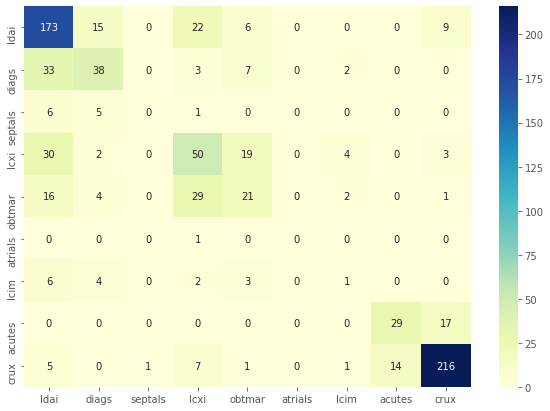

In [215]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, index = [i for i in vessels_names],
                  columns = [i for i in vessels_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt='d')

In [216]:
from matplotlib import style

style.use("ggplot")

def create_acc_loss_graph(train_acc_list, train_loss_list, val_acc_list, val_loss_list):
    epoch = list(range(0, EPOCHS, 1))

    d = {'epochs': epoch,
        'train_acc': train_acc_list,
        'train_loss': train_loss_list,
        'val_acc': val_acc_list, 
        'val_loss': val_loss_list}

    df = pd.DataFrame(d)

    df['train_acc_avg'] = df['train_acc'].ewm(alpha=.02).mean()  # exponential weighted moving average
    df['val_acc_avg'] = df['val_acc'].ewm(alpha=.02).mean()
    df['train_loss_avg'] = df['train_loss'].ewm(alpha=.02).mean()
    df['val_loss_avg'] = df['val_loss'].ewm(alpha=.02).mean()

    # Then plot using pandas:
    df.plot(x='epochs', y=['train_acc_avg', 'val_acc_avg'], figsize=(8,4))
    plt.ylabel("Accuracy")
    df.plot(x='epochs', y=['train_loss_avg', 'val_loss_avg'], figsize=(8,4))
    plt.ylabel("Loss")

    plt.show()

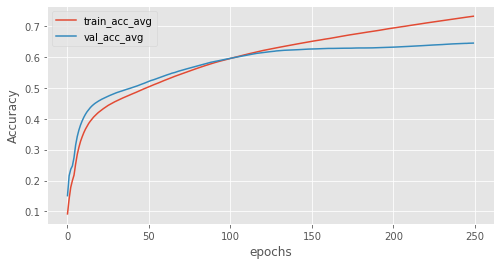

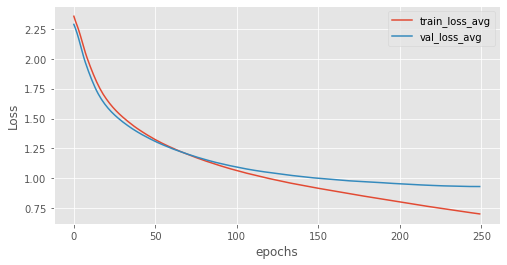

In [217]:
create_acc_loss_graph(train_acc_list, train_loss_list, val_acc_list, val_loss_list)

In [220]:
total_params = sum(p.numel() for p in model.parameters())

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The total params are {total_params} and the trainable one are {trainable_params}")

print (f"Batch size = {BATCH_SIZE}")
print (f"Learning Rate = {alpha}")
print (f"No of Conv layers = 2")
print (f"No of Conv channels = 32")
print (f"Bi-LSTM")
print (f"No of LSTM layers = {nl}")
print (f"No of LSTM units = {nh}")
print (f"No of epochs = {EPOCHS}")

The total params are 16730 and the trainable one are 16730
Batch size = 64
Learning Rate = 0.001
No of Conv layers = 2
No of Conv channels = 32
Bi-LSTM
No of LSTM layers = 1
No of LSTM units = 30
No of epochs = 50
